In [1]:
# import packages
import geopandas as gpd
import os
from requests import get
from urllib.parse import urlparse
import pandas as pd
from pyproj import Transformer
import numpy as np
from pyproj import CRS
from shapely.geometry import Point
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
def cache_data(src:str, dest:str) -> str:
    """
    Downloads a file from the given URL `src` and saves it to the `dest` directory.
    If the file already exists and is of sufficient size, skips the download.
    
    Args:
        src (str): The source URL of the file to be downloaded.
        dest (str): The destination directory where the file will be saved.
        
    Returns:
        str: The full path to the downloaded (or existing) file.
    """    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 250:
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [3]:
# listing data,choose the data of 2024
ymd  = '20240614'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
list_url  = f'{host}/~jreades/data/{ymd}-{city}-listings.parquet'
transport_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/Transport_Classification_of_Londoners_(TCoL)/Transport_Classification_of_Londoners_(TCoL).shp'
inequity_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/Borough_pages_data_UPDATE_9_2024_HACTAR(1).csv'
pop_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/population%20by%20borough.xlsx'
sta_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/London%20stations/London%20stations.shp'
line_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/London%20Train%20Lines/London%20Train%20Lines.shp'
borough_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/Boroughs.gpkg'

In [4]:
# the data frame of datas
listing_df = pd.read_parquet(cache_data(list_url, os.path.join('data','raw')))
# inequity data
inequity = pd.read_csv(cache_data(inequity_url, os.path.join('data','raw')),skiprows=11, header=0)
# population data
pop = pd.read_excel(cache_data(pop_url, os.path.join('data','raw')))
# borough outline
borough = gpd.read_file(cache_data(borough_url, os.path.join('data','raw')))

# station point data
station = gpd.read_file(sta_url)
# train line data
line = gpd.read_file(line_url)
# transport data, spatial unit is OA(output area)
transport = gpd.read_file(transport_url)

Found data/raw/20240614-London-listings.parquet locally!
Found data/raw/Borough_pages_data_UPDATE_9_2024_HACTAR(1).csv locally!
Found data/raw/population%20by%20borough.xlsx locally!
Found data/raw/Boroughs.gpkg locally!


In [5]:
# this is the columns list, if you want to focus on a certain topic, choose some of them
# listing data
columns_list = listing_df.columns.to_list()
print(f'listing data columns: {columns_list}')
print(f"Data frame is {listing_df.shape[0]:,} x {listing_df.shape[1]}")
# transport data
columns_transport = transport.columns.to_list()
print(f'transport data columns: {columns_transport}')
# inequity data
columns_inequity = inequity.columns.to_list()
print(f'inequity data columns: {columns_inequity}')
# population data
columns_pop = pop.columns.to_list()
print(f'population data columns: {columns_pop}')
# station data
columns_station = station.columns.to_list()
print(f'station data columns: {columns_station}')
# line data
columns_line = line.columns.to_list()
print(f'line data columns: {columns_line}')
# borough outline
columns_borough = borough.columns.to_list()
print(f'borough data columns: {columns_borough}')

listing data columns: ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 'host_since', 'host_location', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'reviews_per_month']
Data frame is 85,127 x 31
transport data columns: ['OBJECTID', 'TCOL_SEGME', 'TCOL_SEG_1', 'OA_POPULAT', 'SEGMENT_PO', 'LOAC_SUPER', 'LOAC_GROUP', 'LOAC_SUB_G', 'LOCAL_AUTH', 'PROPENSITY', 'PROPENSI_1', 'PROPENSI_2', 'PROPENSI_3', 'CAR_DRIVER', 'CAR_PASSEN', 'BUS_TRIPS_', 'TRAIN_TRIP', 'RIVER_TRIP', 'TRAM_TRIPS', 'TUBE_TRIPS', 'BICYCLE_TR', 'HIRE_BIKE_', 'DLR_TRIPS_', 'POWERED_TW', 'TAXI_PHV_T', 'WALK_TRIPS', 'CAR_AVAILA', 'AVERAGE_IN', 'STUDENT', 'NO_CHILDRE', 'NO_CHILD_1', 'NO

In [6]:
# Convert df to gdf
listing_df['geometry'] = listing_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
listing_gdf = gpd.GeoDataFrame(listing_df, geometry='geometry', crs="EPSG:4326")
listing_gdf = listing_gdf.to_crs(epsg=27700)

# select columns
geo_list = listing_gdf[['name','geometry']]

# check result
print(geo_list.head())


                                                name  \
0  Rental unit in Earlsfield · ★4.57 · 1 bedroom ...   
1  Rental unit in Hammersmith · ★4.82 · 2 bedroom...   
2  Rental unit in Islington · ★4.80 · 1 bedroom ·...   
3  Rental unit in London · ★4.80 · 1 bedroom · 1 ...   
4  Condo in London · ★4.62 · 1 bedroom · 1 bed · ...   

                        geometry  
0  POINT (526071.772 173004.347)  
1  POINT (523852.404 179394.541)  
2  POINT (530899.228 187213.456)  
3  POINT (527282.901 178129.531)  
4  POINT (539991.817 177170.364)  


In [7]:
# Calculate the number of short-term rental data points contained in each borough
joined_gdf = gpd.sjoin(geo_list, borough, how="inner", predicate="within")
point_counts = joined_gdf.groupby('GSS_CODE').size().reset_index(name='point_count')
#borough.set_index('GSS_CODE', inplace=True)
#borough.reset_index(inplace=True)

# add point count into borough
borough_list = borough.merge(point_counts, on='GSS_CODE', how='left')

# set zero if there is no point
#borough_list['point_count'].fillna(0, inplace=True)


In [8]:
# unify the coordinate system
station = station.to_crs(epsg=27700)
line = line.to_crs(epsg=27700)
# Count the number of underground stations in each borough and join the result to the borough data
station_join = gpd.sjoin(station, borough, how="inner", predicate="within")
station_counts = station_join.groupby('GSS_CODE').size().reset_index(name='station_count')
regression1 = borough_list.merge(station_counts,on='GSS_CODE', how='left')

# Calculate the track length in each borough and join the result to the borough data
line_join = gpd.sjoin(line, borough, how="inner", predicate="within")
line_join['line_length'] = line_join.geometry.length
lengths_per_borough = line_join.groupby('GSS_CODE')['line_length'].sum().reset_index()
regression2 = regression1.merge(lengths_per_borough,on='GSS_CODE', how='left')


In [9]:
# Standardize the format of borough names
inequity['Area'] = inequity['Area'].str.replace('&','and')
# Join the population and inequality index data together
pop_inequity = pd.merge(pop, inequity, left_on='NAME', right_on='Area', how='left')

In [10]:
# join all of the data
regression3 = regression2.merge(pop_inequity,on='GSS_CODE', how='left')

In [11]:
# check the columns
regression_Column = regression3.columns.to_list()
print(regression_Column)

['NAME_x', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'geometry', 'point_count', 'station_count', 'line_length', 'NAME_y', 'POPULATION', 'Area', 'Poverty rate', 'Child poverty rate (AHC)', 'Income deprivation (relative to London overall)', '80:20 ratio of earnings', 'Main homelessness duty owed per 1,000 households', 'Households in temporary accommodation per 1,000', 'Repossessions per 1,000 households', 'Median rent as a percentage of median pay', 'Average net affordable, social and discounted housing completions', 'People seen sleeping rough by outreach', "Proportion of borough residents' jobs that are low paid", 'Unemployment rate', 'Unemployment rate 1 year change', 'Out-of-work benefits', '19 year olds without level 3 qualifications', 'Infant mortality rate per 1,000 live births', 'Deaths of <75 year olds per 100,000', 'Percentage of pupils who achieved grade 9-4', 'Proportion with no qualifications']


In [12]:
# caculate densities
regression4 = regression3[['GSS_CODE','Area','HECTARES','Poverty rate','station_count','line_length','POPULATION','point_count','80:20 ratio of earnings','geometry']]
regression4['population_density'] = regression3['POPULATION'] / regression3['HECTARES']
regression4['airbnb_density'] = regression3['point_count'] / regression3['HECTARES']
regression4['station_density'] = regression3['station_count'] / regression3['HECTARES']
regression4['line_density'] = regression3['line_length'] / regression3['HECTARES']
# select columns for regression,remove NA
regression_all = regression4.drop(columns=['POPULATION', 'HECTARES','point_count','station_count','line_length']).dropna()

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [13]:
# Use short-term rental point data as the dependent variable, excluding the impacts of economy, population, and transportation
X = regression_all.drop(columns=['geometry','airbnb_density','80:20 ratio of earnings','GSS_CODE','Area'])  # independent variables
Y = regression_all['airbnb_density'] 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Principal Component Analysis (PCA) to avoid multicollinearity.
pca = PCA(n_components=0.95)  
X_pca = pca.fit_transform(X_scaled)
# check result
print(f"Number of components selected: {pca.n_components_}")
print(f"Cumulative explained variance ratio: {sum(pca.explained_variance_ratio_):.2f}")
print(X_pca)

Number of components selected: 3
Cumulative explained variance ratio: 0.97
[[-1.42893067e+00 -2.29305204e-01  3.18513056e-02]
 [-5.61973274e-01 -4.62151413e-01  8.29208447e-01]
 [-2.03229615e+00 -7.37397025e-01  6.97413192e-01]
 [-1.05664842e+00  8.10786179e-01 -1.35541269e-01]
 [ 1.93431840e-01  5.07251566e-01  5.99921275e-01]
 [-2.62671533e+00  1.67009874e-02 -1.51146590e-01]
 [-1.65669596e+00  4.33141237e-01  5.14906320e-01]
 [-1.67495575e+00  7.34032511e-02 -5.69205753e-01]
 [ 6.84482870e-01  3.48158101e-01  2.95646840e-01]
 [-1.47235807e+00  5.50176353e-01 -2.49146044e-01]
 [ 1.85943108e+00 -1.17528022e+00  5.58499179e-01]
 [ 1.04046946e+00 -1.42365460e+00  5.86238358e-01]
 [ 1.02339031e+00 -1.71524037e-01  7.24207640e-01]
 [-8.63193448e-01  2.76735635e-01  9.38911928e-03]
 [-1.94075651e+00 -1.69216626e-01 -4.55720800e-05]
 [-8.83494822e-01  1.02561959e+00  2.64565372e-01]
 [-7.72413198e-01 -2.54751520e-01 -3.27920785e-01]
 [-1.20787947e+00  1.06589573e+00 -6.78361360e-01]
 [-1.14

In [14]:
# Split the data into training and testing sets for linear fitting
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

# regression analysis
model = LinearRegression()
model.fit(X_train, Y_train)

r2_train = model.score(X_train, Y_train)
r2_test = model.score(X_test, Y_test)
Y_pred_all = model.predict(X_pca)

# Calculate the residuals for all boroughs
residuals_all = Y - Y_pred_all
print(r2_train)
print(r2_test)
print(residuals_all)

0.8364144295300542
0.8182790588218255
0     0.062471
1    -0.270448
2     0.469750
3    -0.034502
4    -0.466623
5     0.659774
6     0.376119
7    -0.029200
8    -0.682929
9     0.182416
10   -0.491682
11   -0.072233
12   -0.735423
13   -0.040035
14    0.279505
15   -0.088038
16   -0.251470
17   -0.159313
18   -0.087337
20   -0.342050
21    0.090394
22    0.286830
24    1.497735
25   -0.259511
26   -0.134570
27   -0.021253
28    0.563975
29   -0.459844
30   -1.133302
31   -0.176425
Name: airbnb_density, dtype: float64


In [16]:
# Get the coordinates (longitude, latitude) of the centroids of the geometries
coords = regression_all.geometry.centroid.apply(lambda x: (x.x, x.y)).to_list()
# Convert the list of coordinates into a NumPy array
coords = np.array(coords)
# Use the '80:20 ratio of earnings' as an indicator of inequality.
# Extract the values of the '80:20 ratio of earnings' column as the dependent variable
real_y = regression_all['80:20 ratio of earnings'].values 
# Choose residuals from the previous regression model as independent variable
residuals = residuals_all.values 


# Scale the residuals to standardize them
scaler = StandardScaler()
residuals_scaled = scaler.fit_transform(residuals.reshape(-1, 1))
# Scale the real_y values to standardize them
real_y_scaled = scaler.fit_transform(real_y.reshape(-1, 1))
# Add a constant term
X_loc = np.hstack([np.ones((residuals_scaled.shape[0], 1)), residuals_scaled])
# Select the optimal bandwidth
selector = Sel_BW(coords=coords, y=real_y_scaled, X_loc=X_loc)
bandwidth = selector.search(criterion='AICc',bw_min=5, bw_max=15)

print(f"Optimal bandwidth: {bandwidth}")
regression_data = np.column_stack([residuals_scaled, real_y_scaled])

# Fit a Geographically Weighted Regression (GWR) model
gwr_model = GWR(coords = coords, y=real_y_scaled, X = X_loc, bw = bandwidth)
gwr_results = gwr_model.fit()


Optimal bandwidth: 13.0


In [17]:
# Print a summary of the GWR model results
print(gwr_results.summary())

Model type                                                         Gaussian
Number of observations:                                                  30
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             28.667
Log-likelihood:                                                     -41.887
AIC:                                                                 87.773
AICc:                                                                90.696
BIC:                                                                -66.566
R2:                                                                   0.044
Adj. R2:                                                              0.010

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

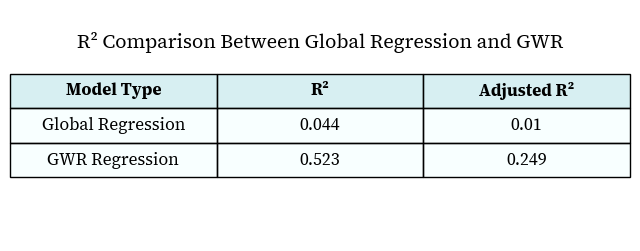

In [18]:
# Define R² and Adjusted R² values for global regression and GWR regression
global_r2 = 0.044
global_adj_r2 = 0.010
gwr_r2 = 0.523
gwr_adj_r2 = 0.249

# Create a dictionary to hold the regression results
results_dict = {
    "Model Type": ["Global Regression", "GWR Regression"],
    "R²": [global_r2, gwr_r2],
    "Adjusted R²": [global_adj_r2, gwr_adj_r2]
}

# Convert the dictionary to DataFrame
results_df = pd.DataFrame(results_dict)

# Create a figure and axis for the table visualization
fig, ax = plt.subplots(figsize=(8,3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, loc='center')

# Customize the appearance of the table cells
for (i, j), cell in table.get_celld().items():
    cell.set_text_props(horizontalalignment='center', verticalalignment='center', fontsize=12,fontname='Source Serif 4')
    if i == 0:
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  
        cell.set_facecolor((176/255, 224/255, 230/255, 0.5)) 
    else:
        cell.set_facecolor((0.878, 1, 1,0.2))
    cell.set_height(0.15)

# Add title, adjust its position
plt.title("R² Comparison Between Global Regression and GWR", fontsize=14,fontname='Source Serif 4',y=0.8)
# Display the table
plt.show()


In [19]:
# representing the local R square
local_r2_values = gwr_results.localR2
print(local_r2_values)

[[ 4.58067384e-01]
 [ 1.24213456e-01]
 [ 3.52191286e-01]
 [ 6.13045676e-01]
 [ 4.74834743e-01]
 [ 1.82627824e-01]
 [ 3.57207826e-01]
 [ 3.28640230e-01]
 [ 5.16433603e-01]
 [ 2.44163025e-01]
 [ 2.47124056e-01]
 [ 4.50532181e-01]
 [ 3.06723158e-01]
 [ 4.90718828e-01]
 [ 4.10042213e-01]
 [-5.35415929e-02]
 [-4.65818696e-05]
 [ 1.82127013e-01]
 [ 2.45438576e-01]
 [ 2.20080360e-01]
 [ 1.74729721e-01]
 [ 7.27986015e-01]
 [ 5.90476867e-01]
 [ 4.64134099e-01]
 [ 4.73818543e-01]
 [ 3.75940239e-01]
 [ 2.97295238e-01]
 [ 1.32547956e-01]
 [ 3.35358673e-01]
 [ 1.87384924e-01]]


In [20]:
# Join the obtained local R² values back to the borough data
regression_all['local_R2'] = local_r2_values
r2_df = regression_all[['GSS_CODE','local_R2']]
borough_r2 = borough.merge(r2_df,on = 'GSS_CODE', how='left')
print(borough_r2)

                      NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  \
0     Kingston upon Thames  E09000021   3726.117       0.000         F   
1                  Croydon  E09000008   8649.441       0.000         F   
2                  Bromley  E09000006  15013.487       0.000         F   
3                 Hounslow  E09000018   5658.541      60.755         F   
4                   Ealing  E09000009   5554.428       0.000         F   
5                 Havering  E09000016  11445.735     210.763         F   
6               Hillingdon  E09000017  11570.063       0.000         F   
7                   Harrow  E09000015   5046.330       0.000         F   
8                    Brent  E09000005   4323.270       0.000         F   
9                   Barnet  E09000003   8674.837       0.000         F   
10                 Lambeth  E09000022   2724.940      43.927         T   
11               Southwark  E09000028   2991.340     105.139         T   
12                Lewisham  E09000023 

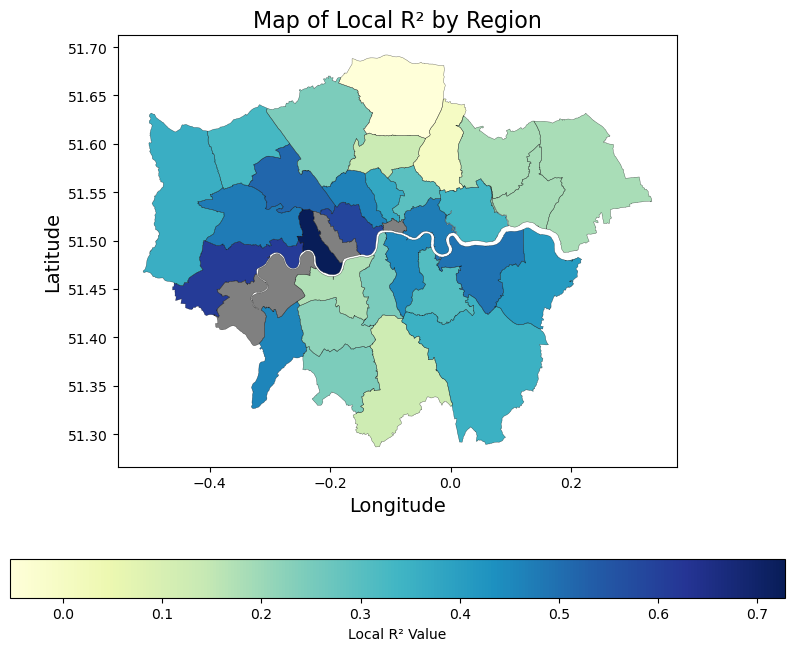

In [27]:

# Convert the coordinate reference system
borough_r2 = borough_r2.to_crs(epsg=4326)
# Replace 'NA' values with NaN
borough_r2['local_R2'] = borough_r2['local_R2'].replace('NA', np.nan)
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the borough data, using the 'local_R2' column to color the map.
borough_r2.plot(column='local_R2', cmap='YlGnBu', legend=True,
                missing_kwds={'color': 'gray', 'label': 'Missing values'},
                legend_kwds={'label': "Local R² Value", 'orientation': "horizontal"},
                ax=ax)
borough_r2.boundary.plot(ax=ax, edgecolor='black', linewidth=0.3,alpha = 0.6)
# Remove grid lines
ax.grid(False)
# Add title and label
plt.title('Map of Local R² by Region',fontsize=16)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
# Display the plot
plt.show()